In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

## Particle deflection calculation
The magnet will deflect an electron of momentum $p$ (in eV/c) according to:

$\theta = \frac{cBd}{p}$

where $Bd$ is the integrated field of the magnet. The horizontal displacement from the beam a distance $l$ down the beamline will be

$\Delta x = l\cdot\tan\theta = l\cdot\tan\Bigr(\frac{cBd}{p}\Bigr)$.

The integrated field for our magnet is $Bd = 0.23\,T\cdot m$.

In [2]:
# Hodoscope parameters
hodo_x_len = 4.2   # Length in x (transverse) direction (cm)
hodo_z_len = 2.0   # Length in z (downstream) direction (cm)
hodo_x_sep = 7.55  # Separation in x (transverse) direction (cm)
hodo_z_sep = 17.0  # Separation in z (downstream) direction (cm)

# Hodoscope positions from MC (in cm)
hodoscope_positions = { 0: (86.9258, 183.884),
                        1: (87.5694, 202.285),
                        2: (79.411,  185.779),
                        3: (80.0546, 204.18),
                        4: (71.8963, 187.674),
                        5: (72.5398, 206.075),
                        6: (64.3815, 189.569),
                        7: (65.025, 207.97),
                        8: (56.8667, 191.464),
                        9: (57.5102, 209.865),
                       10: (49.3519, 193.359),
                       11: (49.9954, 211.76),
                       12: (41.8371, 195.253),
                       13: (42.4806, 213.655),
                       14: (34.3223, 197.148)}

# location of end of magnet in MC (in cm)
end_of_magnet_offset = 7.5

# Maximum length for showing positron path
l_max = 250

# Constants and field
c = 2.99792458e8
Bd = 0.23

### Beam configuration (*fig.beamconfig*)

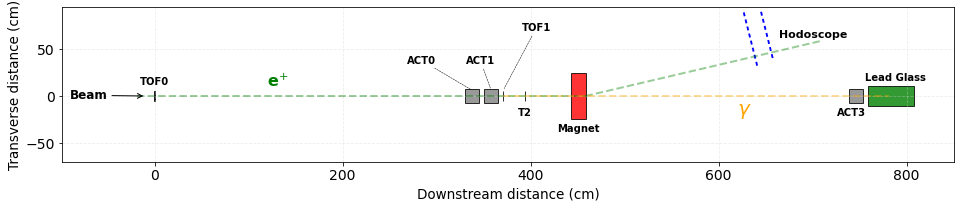

In [3]:
# Helper function to add a callout label
def add_callout_label(ax, point, end, label, labelsize, text_offset=(0,0)):
    ax.annotate(label, 
                xy=point,
                xytext=end,
                arrowprops=dict(arrowstyle='-',linestyle='--',linewidth=0.5,facecolor='black'), # adjust line width and color
                fontsize=labelsize,
                fontweight='bold')

# Detectors to be placed on the drawing
detectors = [
    {'label': 'TOF0', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 15, 'lzoffset': 0, 'center': (0, -450.9), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'ACT0', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -112.9), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'ACT1', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -92.9), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'TOF1', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -80.1), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'T2',   'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -18, 'lzoffset': 0, 'center': (0, -56.9), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'Magnet', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -35, 'lzoffset': 0, 'center': (0, 0), 'x_length': 48, 'z_length': 15, 'color': 'red'},
    {'label': 'ACT3', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -18, 'lzoffset': -5, 'center': (0, 295.1), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'Lead Glass', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 20, 'lzoffset': 5, 'center': (0, 332.35), 'x_length': 20.5, 'z_length': 49.5, 'color': 'green'}
]

xoffset = -450.9

fig, ax = plt.subplots(figsize=(16, 6))
fig.set_facecolor('white')

ax.set_xlim([-550-xoffset,400-xoffset])
ax.set_ylim([-70,95])

# Add gridlines
ax.grid(True, which='both', color='lightgray', alpha=0.4, linestyle='--')

# Add the detectors
for detector in detectors:
    y, x = detector['center']
    x_len, z_len = detector['x_length'], detector['z_length']
    rect = patches.Rectangle((x - z_len/2 - xoffset, y - x_len/2), z_len, x_len, 
                             edgecolor='black', facecolor=detector['color'], alpha=0.8)
    ax.add_patch(rect)
    
    if(not detector['labelcallout']):
        ax.text(x+detector['lzoffset']-xoffset, y+detector['lxoffset'], detector['label'], ha='center', 
                va='center', color='black', fontweight='bold', fontsize=detector['labelsize'], rotation=detector['labelrot'])

# Hodoscope label
ax.text(250-xoffset, 65, "Hodoscope", ha='center', va='center', color='black', fontweight='bold', fontsize=11)

# ACT0 callout label
point_ACT0 = (-112.9-xoffset, 6)
end_ACT0 = (-182.9-xoffset, 35)
add_callout_label(ax, point_ACT0, end_ACT0, "ACT0", detectors[1]['labelsize'], text_offset=(0,30))

# ACT1 callout label
point_ACT1 = (-92.9-xoffset, 6)
end_ACT1 = (-120-xoffset, 35)
add_callout_label(ax, point_ACT1, end_ACT1, "ACT1", detectors[2]['labelsize'], text_offset=(0,30))

# TOF1 callout label
point_TOF1 = (-80.1-xoffset,6)
end_TOF1 = (-60.1-xoffset,70)
add_callout_label(ax, point_TOF1, end_TOF1, "TOF1", detectors[3]['labelsize'], text_offset=(0,30))

# Beam annotation
ax.annotate("Beam", xy=(-10, 0), xytext=(-90, -3),
                arrowprops=dict(arrowstyle='->',facecolor='black'), # adjust line width and color
                fontsize=12,
                fontweight='bold')
    
# Add hodoscope elements and labels
labels_8 = [14, 12, 10, 8, 6, 4, 2, 0]
labels_7 = [13, 11, 9, 7, 5, 3, 1]

for i in range(8):  # First row
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_8[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_8[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x-xoffset, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=1.0)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = (draw_x-xoffset) + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

for i in range(7):  # Second row
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_7[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_7[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x-xoffset, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=1.0)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = (draw_x-xoffset) + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

# ------------------------------------------------------------------------------------------------------
# Plot the e+ and gamma tracks

# e+ along the beam
x_values = np.zeros(100)
z_values = np.linspace(-470, 7.5, 100)
ax.plot(z_values-xoffset, x_values, linestyle='--', linewidth=2, alpha=0.4, color='green')
ax.annotate("e$^{+}$", xy=(120, 10), xytext=(120, 10), fontsize=16, fontweight='bold', color='green')

# e+ after interaction in the magnet.
p_particle = 300
theta = Bd / (p_particle * 1e6 / c)  # calculate the angle at which the particle exits the magnetic field
z_values = np.linspace(0, l_max, 100)
dX_values = z_values * np.tan(theta)
ax.plot(z_values-xoffset+7.5, dX_values, linestyle='--', linewidth=2, alpha=0.4, color='green')

# gamma path
x_values = np.zeros(100)
z_values = np.linspace(-80.1, 330, 100)
ax.plot(z_values-xoffset, x_values, linestyle='--', linewidth=2, alpha=0.4, color='orange')
ax.annotate("$\gamma$", xy=(320, 10), xytext=(620, -20), fontsize=20, fontweight='bold', color='orange')

# ------------------------------------------------------------------------------------------------------
    
# Add a legend
#ax.legend(fontsize=13)

# Add labels and title
ax.set_xlabel('Downstream distance (cm)',fontsize=13.5)
ax.set_ylabel('Transverse distance (cm)',fontsize=13.5)
#ax.set_title('Approx. electron trajectories for different momenta',fontsize=18)

# Equal aspect ratio
ax.set_aspect('equal')

# Set larger tick marks
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("beamline.pdf", bbox_inches='tight')

### Calculation of energy for each hodoscope position (for use in *fig.LG_calibration*)

In [5]:
momenta_c = {}
momenta_l, momenta_r = {}, {}
momenta_delta = {}
for elem, (x, z) in hodoscope_positions.items():

    z -= end_of_magnet_offset
    
    # Calculate the angle theta
    theta_c = np.arctan2(x, z)
    theta_l = np.arctan2(x+hodo_x_len/2, z)
    theta_r = np.arctan2(x-hodo_x_len/2, z)

    # Calculate the momentum in GeV/c
    p_c = Bd * c / theta_c / 1e9  # convert to GeV/c from kg*m/s
    p_l = Bd * c / theta_l / 1e9
    p_r = Bd * c / theta_r / 1e9
    
    # Store the calculations
    momenta_c[elem] = p_c
    momenta_l[elem] = p_l
    momenta_r[elem] = p_r
    momenta_delta[elem] = p_r - p_l

In [6]:
print("Approx. momentum range due to size of hodoscope elements:")
for elem in momenta_c.keys():
    p_deltac = momenta_delta[elem]/momenta_c[elem]
    print("-- Elem {}, range = {}, range/mean = {}".format(elem,momenta_delta[elem],p_deltac))

Approx. momentum range due to size of hodoscope elements:
-- Elem 0, range = 0.0063047132725456145, range/mean = 0.041867426126845936
-- Elem 1, range = 0.006932943602899561, range/mean = 0.0424806948921434
-- Elem 2, range = 0.007724812094032252, range/mean = 0.04694648026319769
-- Elem 3, range = 0.00845980150260986, range/mean = 0.047426301134682936
-- Elem 4, range = 0.009627122746240724, range/mean = 0.05301053304896092
-- Elem 5, range = 0.010498277293921526, range/mean = 0.05332570951453302
-- Elem 6, range = 0.01225191220751115, range/mean = 0.060393567887580275
-- Elem 7, range = 0.013300445377746856, range/mean = 0.06050209859545257
-- Elem 8, range = 0.016009392120709398, range/mean = 0.06960812308447864
-- Elem 9, range = 0.017294611862594872, range/mean = 0.06944963413894434
-- Elem 10, range = 0.02164736408549034, range/mean = 0.08148330933697945
-- Elem 11, range = 0.023256557966043867, range/mean = 0.0809632798489735
-- Elem 12, range = 0.030648203744867764, range/mean 

In [7]:
momenta_delta
#momenta_c

{0: 0.0063047132725456145,
 1: 0.006932943602899561,
 2: 0.007724812094032252,
 3: 0.00845980150260986,
 4: 0.009627122746240724,
 5: 0.010498277293921526,
 6: 0.01225191220751115,
 7: 0.013300445377746856,
 8: 0.016009392120709398,
 9: 0.017294611862594872,
 10: 0.02164736408549034,
 11: 0.023256557966043867,
 12: 0.030648203744867764,
 13: 0.03271156068397968,
 14: 0.04630141916160452}

---

## Additional plots

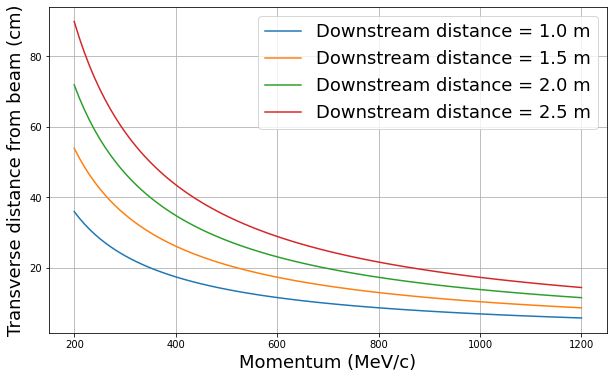

In [4]:
# Momentum values (in MeV/c)
p_values = np.linspace(200, 1200, 100)

# Downstream distances (in m)
l_values = np.arange(1.0, 2.6, 0.5)

plt.figure(figsize=(10, 6))
for l in l_values:
    
    # Calculate the transverse distance (in m)
    dX_values = l * np.tan(Bd / (p_values * 1e6 / c)) * 100

    # Plot dX vs p for this l
    plt.plot(p_values, dX_values, label=f'Downstream distance = {l:.1f} m')
    
plt.ylabel("Transverse distance from beam (cm)",fontsize=18)
plt.xlabel("Momentum (MeV/c)",fontsize=18)
plt.legend(fontsize=18)
plt.grid()

## Rotated hodoscope orientation

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
fig.set_facecolor('white')

xdist_hodoscope = 35.0

# Momentum range in GeV/c
p_values = np.linspace(200, 1200, 11)
p_start = p_values[0]
p_stop = p_values[-1]
p_step = p_values[1]-p_values[0]

# Loop over the momentum values
for p in p_values:
    
    # Calculate the angle at which the particle exits the magnetic field
    theta = Bd / (p * 1e6 / c)

    # Calculate the transverse distance (in m) at a range of downstream distances
    l_values = np.linspace(0, l_max, 100)
    dX_values = l_values * np.tan(theta)

    # Plot dX vs l for this momentum
    ax.plot(l_values, dX_values, label=f'p = {p:.0f} MeV/c')
    
# Add hodoscope elements and labels
labels_8 = [14, 12, 10, 8, 6, 4, 2, 0]
labels_7 = [13, 11, 9, 7, 5, 3, 1]

for i in range(8):  # First row
    #     ax.add_patch(patches.Rectangle((l_hodoscope, xdist_hodoscope + i*hodo_x_sep),
    #                                    hodo_z_len, hodo_x_len, facecolor='blue', alpha=0.8))
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_8[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_8[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=0.8)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = draw_x + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

    #ax.text(l_hodoscope + 4.5*hodo_z_len/2, xdist_hodoscope + i*hodo_x_sep + hodo_x_len/2, str(labels_8[i]),
    #        color='black', ha='center', va='center')

for i in range(7):  # Second row
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_7[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_7[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=0.8)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = draw_x + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

    #ax.add_patch(patches.Rectangle((l_hodoscope + hodo_z_sep/2, xdist_hodoscope + hodo_x_sep/2 + i*hodo_x_sep),
    #                               hodo_z_len, hodo_x_len, facecolor='blue', alpha=0.8))
    #ax.text(l_hodoscope + 1.5*hodo_z_sep/2 + hodo_z_len/2, xdist_hodoscope + hodo_x_sep/2 + i*hodo_x_sep + hodo_x_len/2, str(labels_7[i]),
    #        color='black', ha='center', va='center')

# Add gridlines
ax.grid(True, which='both', color='gray', linestyle='--')

# Add a legend
ax.legend(fontsize=13)

# Add labels and title
ax.set_xlabel('Downstream distance from end of magnet (cm)',fontsize=18)
ax.set_ylabel('Transverse distance (cm)',fontsize=18)
#ax.set_title('Approx. electron trajectories for different momenta',fontsize=18)

# Equal aspect ratio
ax.set_aspect('equal')

# Add a small box representing the magnet at the origin and label it
ax.add_patch(patches.Rectangle((-15, -12), 15, 24, facecolor='red', alpha=0.5))
ax.text(-22.5, -5, 'Magnet', fontsize=12, color='red',rotation=90)

# Set larger tick marks
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("electron_trajectories.png", bbox_inches='tight')

## Old code

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8.0))

l_max = 250
l_hodoscope = 200
xdist_hodoscope = 35.0

# Momentum range in GeV/c
p_values = np.linspace(200, 1200, 11)
p_start = p_values[0]
p_stop = p_values[-1]
p_step = p_values[1]-p_values[0]

# Loop over the momentum values
for p in p_values:
    
    # Calculate the angle at which the particle exits the magnetic field
    theta = Bd / (p * 1e6 / c)

    # Calculate the transverse distance (in m) at a range of downstream distances
    l_values = np.linspace(0, l_max, 100)
    dX_values = l_values * np.tan(theta)

    # Plot dX vs l for this momentum
    ax.plot(dX_values, l_values, label=f'p = {p:.1f} MeV/c')
    
# Add hodoscope elements 
for i in range(8):  # First row
    ax.add_patch(patches.Rectangle((xdist_hodoscope + i*hodo_x_sep, l_hodoscope),
                                   hodo_x_len, hodo_z_len, facecolor='blue', alpha=0.8))

for i in range(7):  # Second row
    ax.add_patch(patches.Rectangle((xdist_hodoscope + hodo_x_sep/2 + i*hodo_x_sep, l_hodoscope + hodo_z_sep/2),
                                   hodo_x_len, hodo_z_len, facecolor='blue', alpha=0.8))

# Add gridlines
ax.grid(True, which='both', color='gray', linestyle='--')

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Transverse distance from beam (cm)',fontsize=18)
ax.set_ylabel('Downstream distance (cm)',fontsize=18)
ax.set_title('Approx. electron trajectories for different momenta',fontsize=18)